In [129]:
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import hamming_loss, accuracy_score, roc_auc_score

from keras.models import Sequential
from keras.layers import TimeDistributed, Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical  

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [130]:
def circ_shift_chord(y, a):
    if y == 0:
        return y
    elif y < 13:
        return 1 + np.mod(y + a - 1, 12)
    else:
        return 13 + np.mod(y + a - 13, 12)

# print(circ_shift_chord(0, 1))
# print(circ_shift_chord(12, 1))
# print(circ_shift_chord(24, 1))

#np.set_printoptions(precision=2)
#print(X_train_orig[100:102, :])
#X_rolled = np.roll(X_train_orig, 1)
#print(X_rolled[100:102, :])

#Y_train_orig_full = np.zeros(Y_train_orig.shape)
#for m in range(X_train_orig.shape[0]):
#    Y_train_orig_full[m] = circ_shift_chord(Y_train_orig[m], 1)

#Y_rolled = np.concatenate((Y_train_orig[:,0:1], np.roll(Y_train_orig[:, 1:13], 1), np.roll(Y_train_orig[:, 13:25], 1)), axis=1)
#print(Y_rolled.shape)

#print(Y_train_orig[100:102, :])
#print(Y_rolled[100:102, :])
#Y_train_orig[circ_shift_chord(Y_train_orig[100:102], 1) for y in Y_train_orig]

In [131]:
dataset = np.load('dataset.npz')
X_train_orig_raw, Y_train_orig_raw, X_test_orig, Y_test_orig = dataset['x_train'], dataset['y_train'], \
    dataset['x_test'], dataset['y_test']
    
Y_train_orig_raw = to_categorical(Y_train_orig_raw, num_classes=25)
Y_test_orig = to_categorical(Y_test_orig, num_classes=25)

for d in [X_train_orig_raw, X_test_orig, Y_train_orig_raw, Y_test_orig]:
    print(d.shape)

# shift circularly to balance chords
X_train_orig = X_train_orig_raw
Y_train_orig = Y_train_orig_raw
for i in range(1,12):
    X_rolled = np.roll(X_train_orig_raw, i)
    Y_rolled = np.concatenate((Y_train_orig_raw[:,0:1], np.roll(Y_train_orig_raw[:, 1:13], i), np.roll(Y_train_orig_raw[:, 13:25], i)), axis=1)
    X_train_orig = np.concatenate((X_train_orig, X_rolled), axis=0)
    Y_train_orig = np.concatenate((Y_train_orig, Y_rolled), axis=0)
    
feature_count = X_train_orig.shape[1]
target_count = Y_train_orig.shape[1]  

def normalize(X):
    return (X.astype('float32') - 120) / (X.shape[1] - 120)

#X_train_orig = normalize(X_train_orig)
#X_test_orig = normalize(X_test_orig)
    
for d in [X_train_orig, X_test_orig, Y_train_orig, Y_test_orig]:
    print(d.shape)

(1107814, 12)
(127700, 12)
(1107814, 25)
(127700, 25)
(13293768, 12)
(127700, 12)
(13293768, 25)
(127700, 25)


In [136]:
np.sum(Y_train_orig, axis=0)

array([391188., 865271., 865271., 865271., 865271., 865271., 865271.,
       865271., 865271., 865271., 865271., 865271., 865271., 209944.,
       209944., 209944., 209944., 209944., 209944., 209944., 209944.,
       209944., 209944., 209944., 209944.])

In [137]:
# we'll cut the datasets into small sequences of frames
max_seq_size = 32

In [138]:
# we discard some frames (better would be to pad)

def cut_sequences(a, max_seq_size):
    n = len(a)
    n_cut = len(a) - len(a) % max_seq_size
    return a[:n_cut].reshape(-1, max_seq_size, a.shape[1])

X_train_seq = cut_sequences(X_train_orig, max_seq_size)
X_test_seq = cut_sequences(X_test_orig, max_seq_size)
Y_train_seq = cut_sequences(Y_train_orig, max_seq_size)
Y_test_seq = cut_sequences(Y_test_orig, max_seq_size)

for d in [X_train_seq, X_test_seq, Y_train_seq, Y_test_seq]:
    print(d.shape)
    
Y_train_flat = Y_train_seq.reshape(-1, target_count)
Y_test_flat = Y_test_seq.reshape(-1, target_count)

(132937, 100, 12)
(1277, 100, 12)
(132937, 100, 25)
(1277, 100, 25)


In [139]:
X_train_seq_conv = X_train_seq.reshape(X_train_seq.shape[0], max_seq_size, feature_count, 1)
X_test_seq_conv = X_test_seq.reshape(X_test_seq.shape[0], max_seq_size, feature_count, 1)

X_train = X_train_seq_conv
X_valid = X_test_seq_conv
Y_train = Y_train_seq
Y_valid = Y_test_seq

In [140]:
batch_size = 128

In [147]:
model = Sequential()

model.add(TimeDistributed(Convolution1D(32, 3, activation='relu'), input_shape=(max_seq_size, feature_count, 1)))
model.add(TimeDistributed(Convolution1D(32, 3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2, 2)))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(25, activation='softmax')))

In [148]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('param count:', model.count_params())
print('input shape:', model.input_shape)
print('output shape:', model.output_shape)

param count: 87801
input shape: (None, 100, 12, 1)
output shape: (None, 100, 25)


In [149]:
hist = model.fit(X_train, Y_train,
          validation_data=(X_valid, Y_valid),
          epochs=10, batch_size=batch_size)

/usr/local/lib/python3.5/dist-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 132937 samples, validate on 1277 samples
Epoch 1/10
  3904/132937 [..............................] - ETA: 37:22 - loss: 2.5790 - acc: 0.3074

KeyboardInterrupt: 

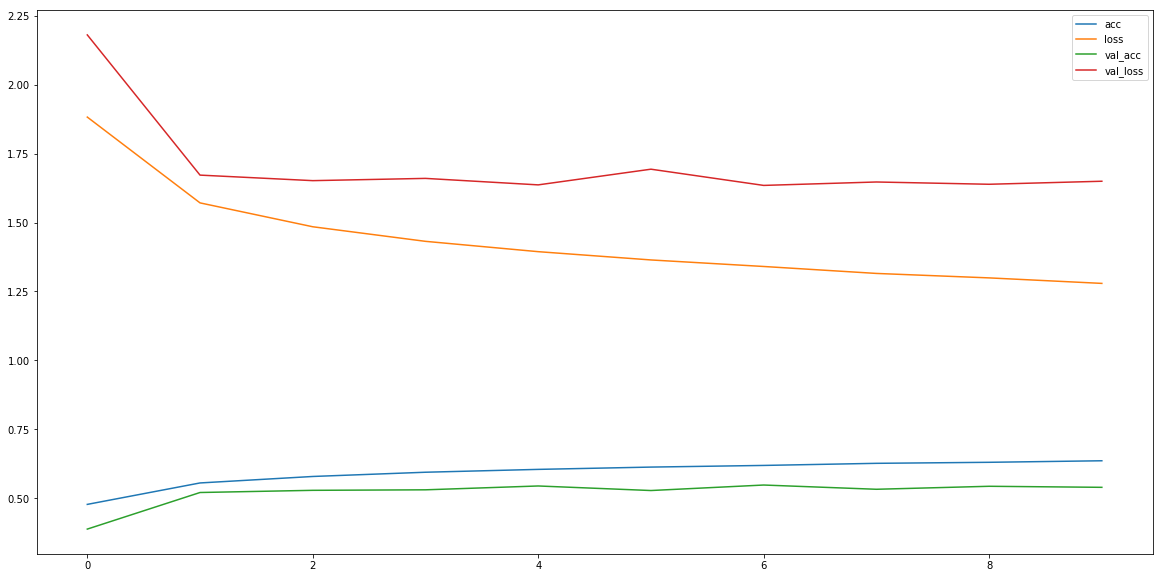

In [33]:
for label in sorted(hist.history):
    plt.plot(hist.history[label], label=label)
plt.legend();

In [50]:
def predict(model, X):
    Y_proba = model.predict(X, batch_size=batch_size, verbose=1).reshape(-1, target_count)
    return Y_proba, np.argmax(Y_proba, axis=1)

#Y_train_proba, Y_train_classes = predict(model, X_train)
Y_valid_proba, Y_valid_classes = predict(model, X_valid)

1277/1277 [==============================] - 2s 1ms/step


In [52]:
print(Y_valid_proba.shape)
print(Y_valid_classes.shape)

(127700, 25)
(127700,)


In [44]:
def evaluate_model(model, Y_true, Y_pred_classes, Y_pred_proba):
    print('accuracy:', accuracy_score(Y_true, Y_pred_classes))
    print('hamming score:', 1 - hamming_loss(Y_true, Y_pred_classes))
    print('AUC:', roc_auc_score(Y_true.flatten(), Y_pred_proba.flatten()))

print('-- training:')
evaluate_model(model, Y_train_flat, Y_train_classes, Y_train_proba)
print('-- validation:')
evaluate_model(model, Y_test_flat, Y_valid_classes, Y_valid_proba)

-- training:
accuracy: 0.5562944574833002
hamming score: 0.976779888066438
AUC: 0.9670840833747504
-- validation:
accuracy: 0.4162176977290525
hamming score: 0.9684422866092404
AUC: 0.9285320335618813


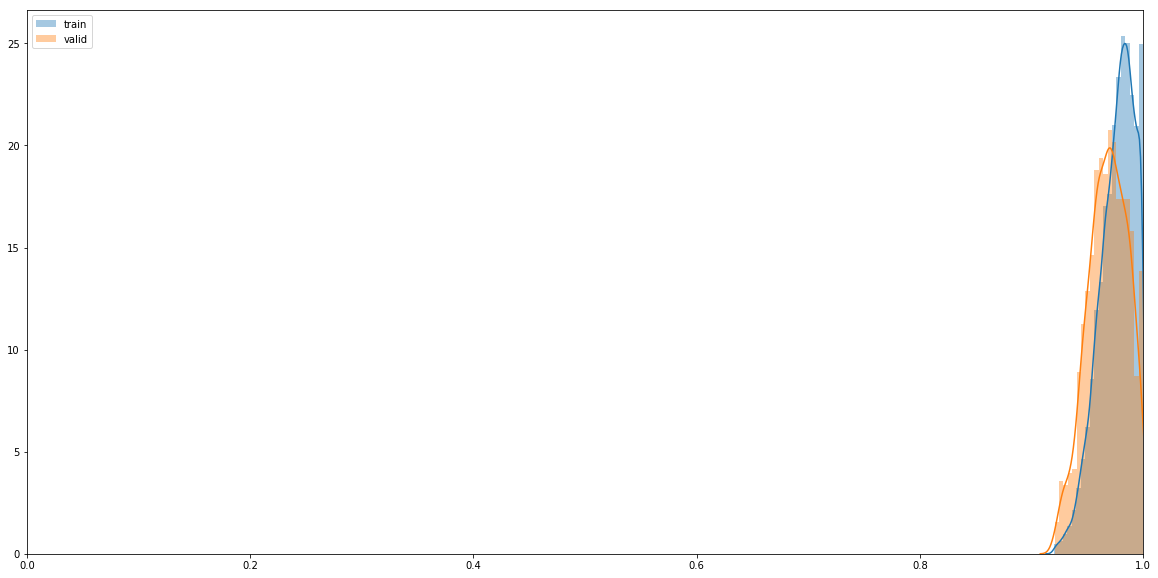

In [45]:
def hamming_score_dist_by_samples(Y_true, Y_pred_classes):
    Y_pred_classes_seq = Y_pred_classes.reshape(-1, max_seq_size, target_count)
    return np.array([1 - hamming_loss(Y_true[i], Y_pred_classes_seq[i]) for i in range(Y_true.shape[0])])

sns.distplot(hamming_score_dist_by_samples(Y_train, Y_train_classes), bins=20, label='train')
sns.distplot(hamming_score_dist_by_samples(Y_valid, Y_valid_classes), bins=20, label='valid')
plt.xlim(0, 1)
plt.legend();

In [49]:
from keras.models import load_model
model.save('chord_model.h5')  # creates a HDF5 file 'my_model.h5'
#https://transcranial.github.io/keras-js-docs/conversion/
!./keras-js/python/encoder.py -q chord_model.h5

Saved to binary file /mnt/7242E92A14D9DC21/tf/KerasJs Chord Detection/chord_model.bin
